# Data download and prep

- installing modules
- downloading data from kaggle
- generating masks
- saving to pandas dataframe
- pickle to save to file

In [ ]:
import sys
! {sys.executable} -m pip install kaggle --upgrade
! {sys.executable} -m pip install shapely --upgrade
! {sys.executable} -m pip install tifffile --upgrade

In [ ]:
kaggle competitions download -c dstl-satellite-imagery-feature-detection -f three_band.zip
kaggle competitions download -c dstl-satellite-imagery-feature-detection -f train_wkt_v4.csv
kaggle competitions download -c dstl-satellite-imagery-feature-detection -f grid_sizes.csv

# Mask generator helpers
Most of these functions come from Kaggle competition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

N_Cls = 1
inDir = 'dataset/kaggle'
DF = pd.read_csv(inDir + '/train_wkt_class4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
ISZ = 160
smooth = 1e-12


def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


# Tiff to Jpeg helpers

In [2]:
import numpy as np

def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)

In [3]:
import os
import numpy as np
import tifffile as tiff

def M(file_path):
    img = tiff.imread(file_path)    
    img = np.rollaxis(img, 0, 3)
    return img

In [4]:
import os
import tifffile as tiff

def tif_2_jpg(img_id, data_dir="dataset/kaggle/three_band/"):
    image_path = os.path.join(data_dir, img_id + ".tif")
    im_tiff = M(image_path)
    im_tiff_8 = stretch_8bit(im_tiff)
    return im_tiff_8

# Test tiff to jpg for a single image

In [5]:
image_id = "6040_2_2"
im_tiff_8 = tif_2_jpg(image_id)

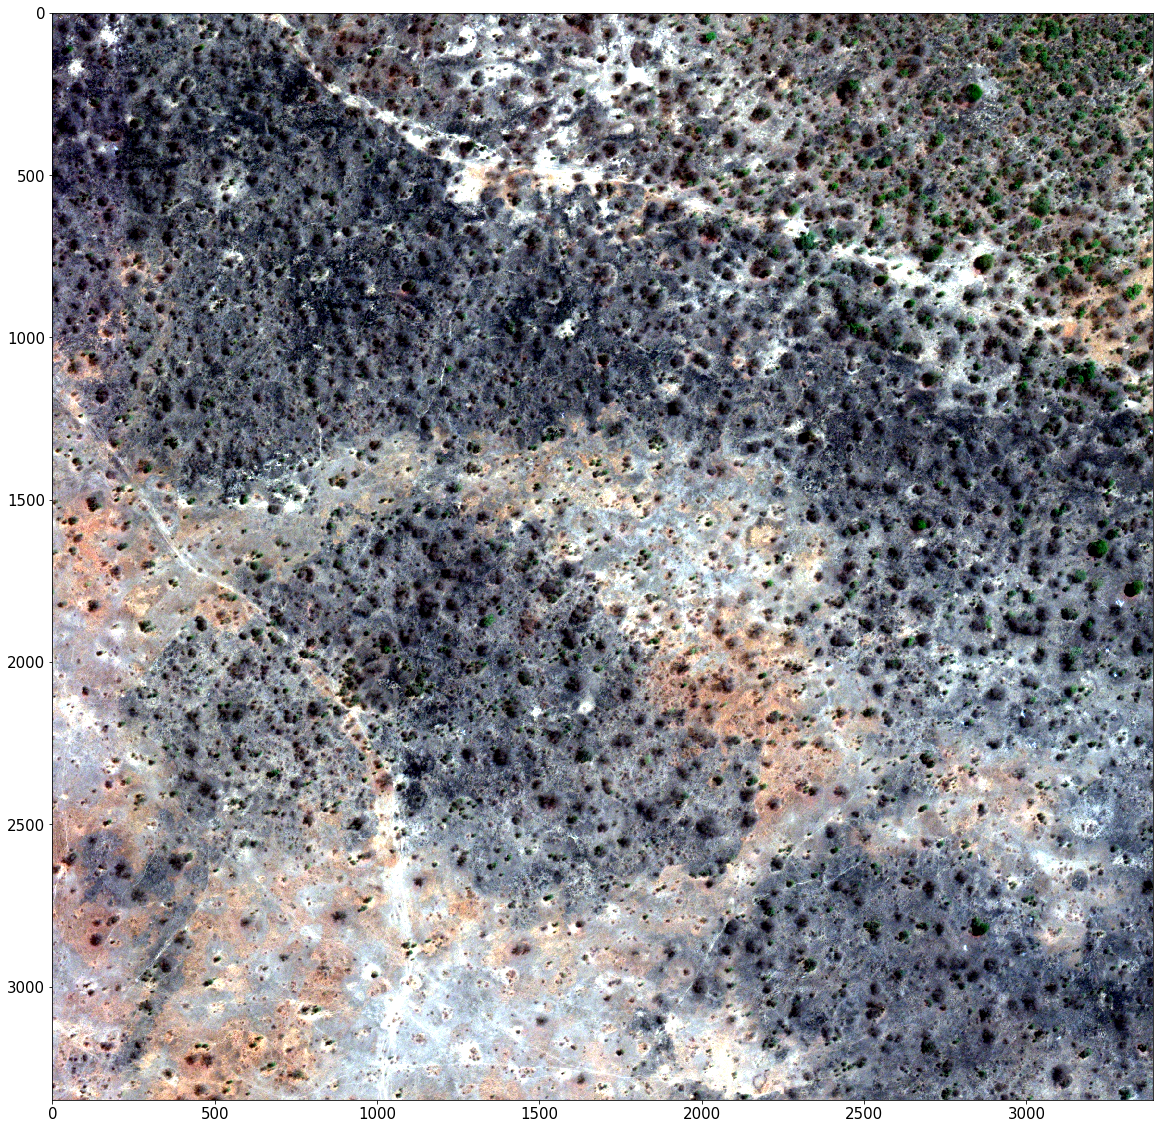

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.imshow(im_tiff_8)

# Testing saving to jpg

In [ ]:
from PIL import Image

im = Image.fromarray(im_tiff_8)
im.save(image_path.replace(".tif",".jpg").replace("three_band","class4_jpg"), "JPEG")

# Load data into DataFrame
Selecting images with ClassType=4 only

In [8]:
import pandas as pd

df_train_wkt = pd.read_csv("dataset/kaggle/train_wkt_v4.csv")

df_class4 = df_train_wkt[df_train_wkt["ClassType"] == 4]

df_class4.to_csv("train_wkt_class4.csv")

# Generate image data and add as new column in the dataframe
Applying tif_2_jpg function

In [9]:
df_class4_new = df_class4

In [10]:
df_class4_new['img_data'] = df_class4_new.apply(lambda x: tif_2_jpg(x['ImageId']), axis=1)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Test and visualize single image

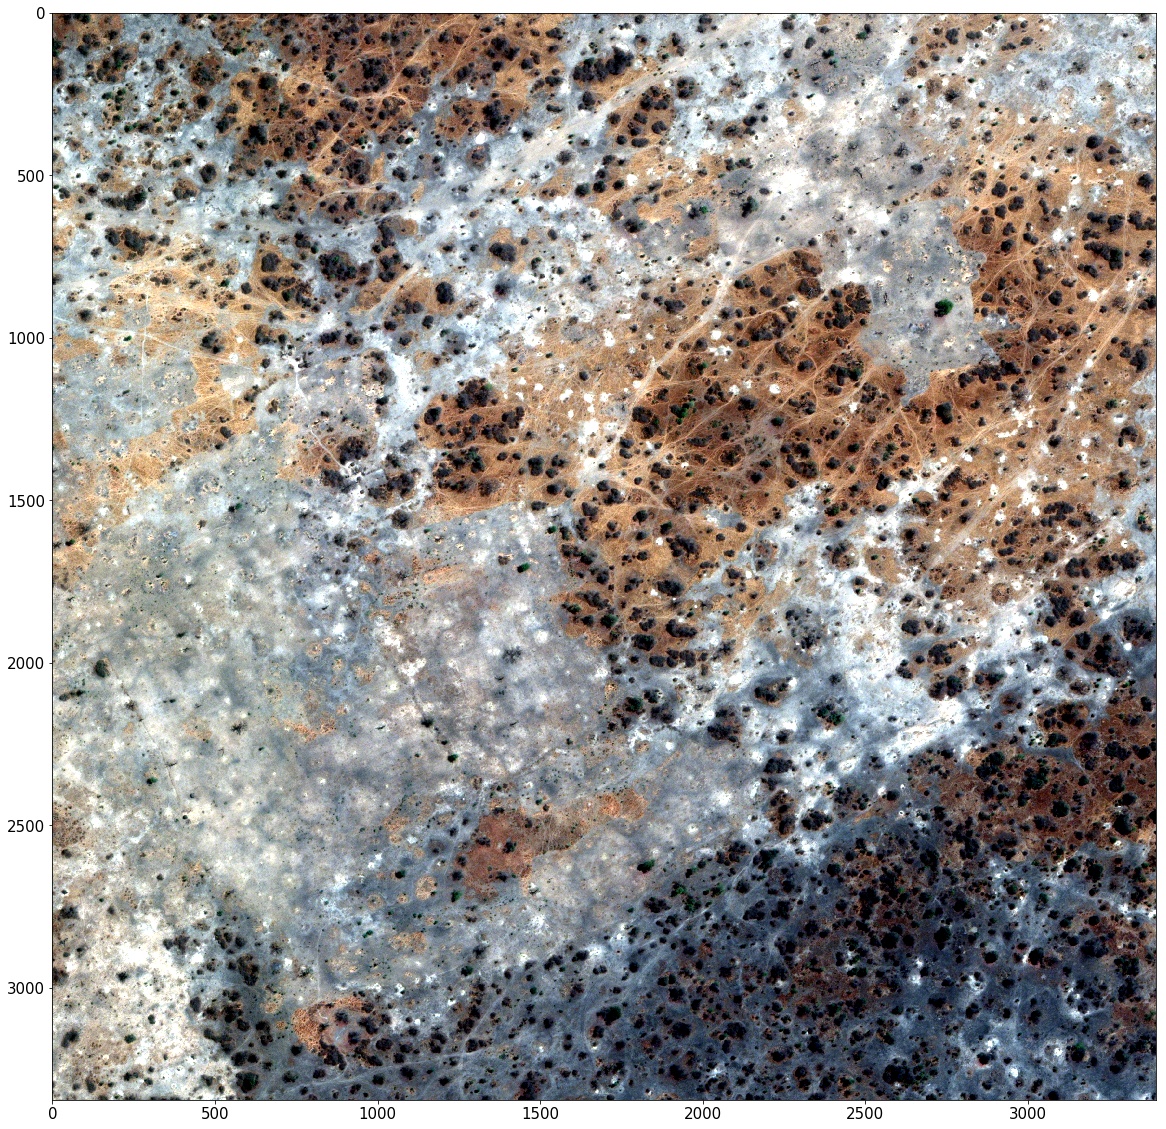

In [11]:
sample_img = df_class4_new[df_class4_new["ImageId"] == "6010_4_2"].iloc[0,3]

plt.figure(figsize=(20, 20))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.imshow(sample_img)

# Generate mask data for the dataset and add as new column

In [12]:
def generate_mask(image_id, im_shape, class_n=4):    
    return generate_mask_for_image_and_class((im_shape[0], im_shape[1]), image_id, class_n)

In [13]:
df_class4_new['mask_data'] = df_class4_new.apply(lambda x: generate_mask(x['ImageId'], x['img_data'].shape), axis=1)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Test and visualize single mask

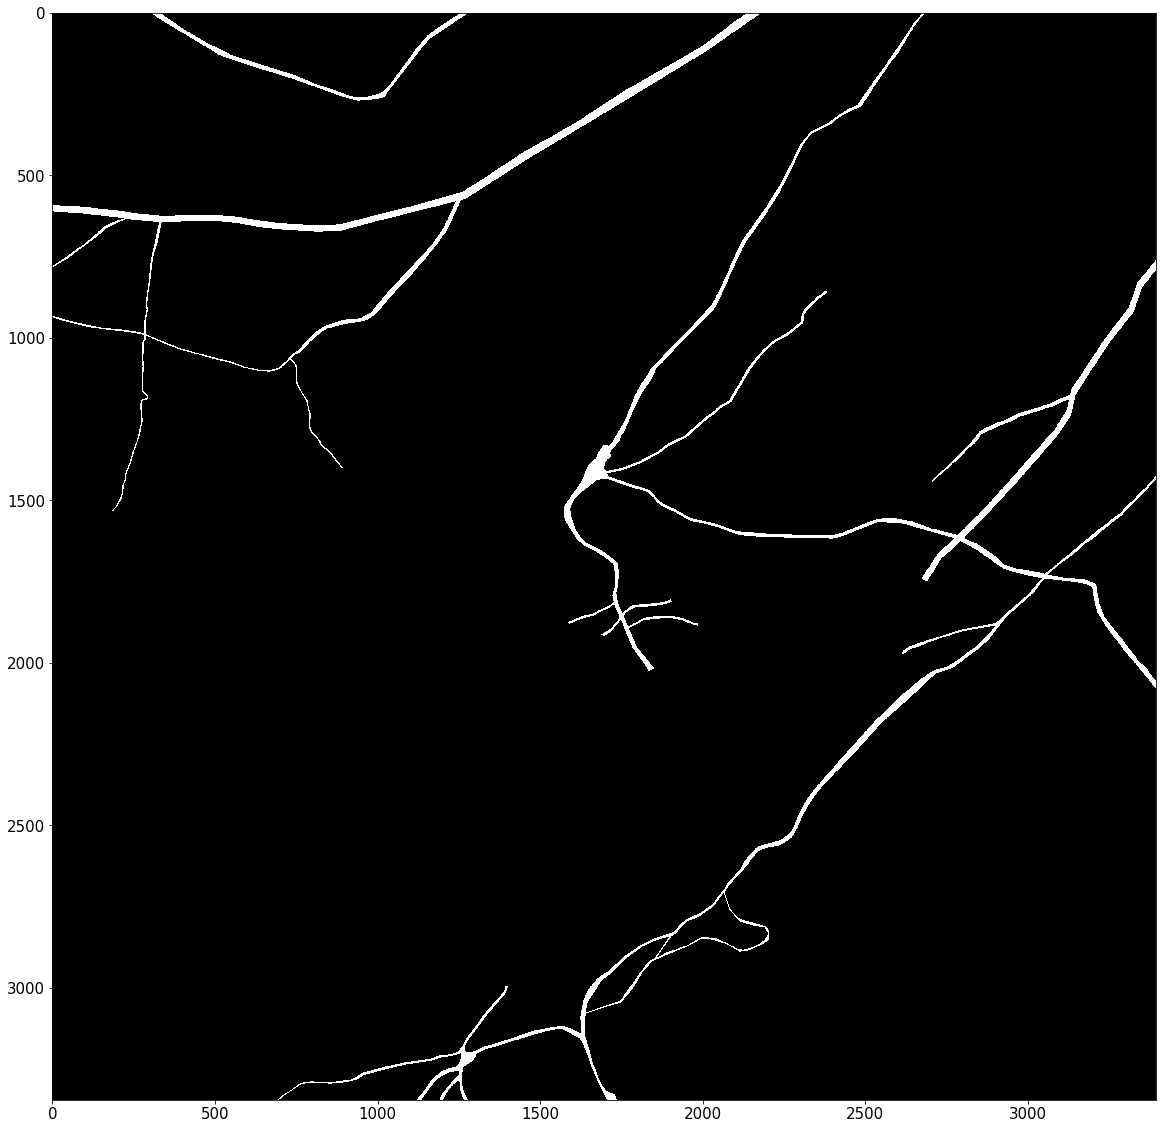

In [14]:
sample_mask = df_class4_new[df_class4_new["ImageId"] == "6010_4_2"].iloc[0,4]

plt.figure(figsize=(20, 20))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.imshow(sample_mask, cmap='gray')

# Save the whole dataset into pickle file

In [ ]:
import pickle

with open(r"dataset/kaggle/challenge8_dataset.pickle", "wb") as output_file:
    pickle.dump(df_class4_new, output_file)